In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from math import radians, sin, cos


def set_axes_equal(ax):
# 这一段是copy别人的。用处不是很大。
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.
    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def dh_matrix(alpha, a, d, theta):
# 传入四个DH参数，根据公式3-6，输出一个T矩阵。
    alpha = alpha / 180 * np.pi
    theta = theta / 180 * np.pi
    matrix = np.identity(4)
    matrix[0,0] = cos(theta)
    matrix[0,1] = -sin(theta)
    matrix[0,2] = 0
    matrix[0,3] = a
    matrix[1,0] = sin(theta)*cos(alpha)
    matrix[1,1] = cos(theta)*cos(alpha)
    matrix[1,2] = -sin(alpha)
    matrix[1,3] = -sin(alpha)*d
    matrix[2,0] = sin(theta)*sin(alpha)
    matrix[2,1] = cos(theta)*sin(alpha)
    matrix[2,2] = cos(alpha)
    matrix[2,3] = cos(alpha)*d
    matrix[3,0] = 0
    matrix[3,1] = 0
    matrix[3,2] = 0
    matrix[3,3] = 1
    return matrix



In [80]:
joint_num = 4

# --- Robotic Arm construction ---
# DH参数表，分别用一个列表来表示每个关节的东西。
#应该是3个轴，但3轴的建模仅能表示到第三轴上，因此假装有第四轴存在
joints_alpha = [0, 90, 0, 0]
joints_a = [0, 0, 20, 20]
joints_d = [13.5 ,0, 0, 0]
joints_theta = [0, 77, -56, 110]

#    Joint Angle variables
# joints_angle = [-0.001, -21.0, -0.001, -21.0, 0.0, 0.0, -0.0]
# 选定几个特定的关节角，看看算出来的值，和真实值是否一致，方向是否反了。
input_angle1= -0  #电机x的转角，控制第一轴
input_angle2= -0  #电机y的转角，控制第二轴
input_angle3= -0  #电机z的转角，电机z与电机y共同控制第三轴
#注意，由于这个机械臂上的菱形曲轴连杆机构，输入电机角度和轴角度之间不是一一对应
#这个机械臂与常见的四轴六轴运动方式不同，对于一般机械臂，某个轴相对基坐标转动a度，则带动之后的所有机械结构均转动a度
#但在这个机械臂上，第二臂转动a度，第三臂相对基坐标的角度不变
#在仅有电机y转动时，第二轴和第二臂的转角与电机y转角相同，但第三轴相对于基坐标的角度并不发生变化，第三臂在空间中不发生转动仅发生平移
#即，theta2增大多少，theta3就自动减小多少，反之亦然(注：在这个代码中joint_theta与joint_angle的和为DH公式中的theta)

joints_angle = [input_angle1, input_angle2, input_angle3-input_angle2, 0]  #三个转轴的转角，和控制器上一样用负数表示，第四轴是假的，暂定为0
#    DH参数转转换矩阵T---------------------
joint_hm = []
for i in range(joint_num):        
    joint_hm.append(dh_matrix(joints_alpha[i], joints_a[i], joints_d[i], joints_theta[i]+joints_angle[i]))

joint_hm

[array([[ 1. , -0. ,  0. ,  0. ],
        [ 0. ,  1. , -0. , -0. ],
        [ 0. ,  0. ,  1. , 13.5],
        [ 0. ,  0. ,  0. ,  1. ]]),
 array([[ 2.24951054e-01, -9.74370065e-01,  0.00000000e+00,
          0.00000000e+00],
        [ 5.96629591e-17,  1.37742794e-17, -1.00000000e+00,
         -0.00000000e+00],
        [ 9.74370065e-01,  2.24951054e-01,  6.12323400e-17,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 0.5591929 ,  0.82903757,  0.        , 20.        ],
        [-0.82903757,  0.5591929 , -0.        , -0.        ],
        [-0.        ,  0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[-0.34202014, -0.93969262,  0.        , 20.        ],
        [ 0.93969262, -0.34202014, -0.        , -0.        ],
        [ 0.        , -0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])]

[ 0.  -0.  13.5]
[ 0.   0.  13.5]
[ 4.49902  0.      32.9874 ]
[23.17063  0.      40.15476]


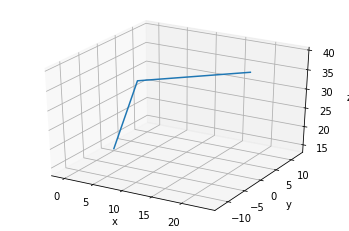

In [81]:
# -----------连乘计算----------------------
for i in range(joint_num-1):
    joint_hm[i+1] = np.dot(joint_hm[i], joint_hm[i+1])    
# Prepare the coordinates for plotting
for i in range(joint_num):
    print(np.round(joint_hm[i][:3, 3], 5))
# 获取坐标值
X = [hm[0, 3] for hm in joint_hm]
Y = [hm[1, 3] for hm in joint_hm]
Z = [hm[2, 3] for hm in joint_hm]
# Plot
ax = plt.axes(projection='3d')
# ax.set_aspect('equal')
ax.plot3D(X, Y, Z)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

set_axes_equal(ax)
plt.show()


##出现的问题：三轴不是随着二周以及二轴驱臂运动而运动的，三轴的角度具有稳定性，三轴的角度不随二轴移动，具有相对于基座的稳定性，草，不能直接算
##找到第三轴电动机角度与第三臂和第二臂夹角的关系
##二轴的转动不会带动三臂发生角度的运动，只有二轴的位置是对的，三臂的运算中需要减去二轴的角度？？
##在原本的运算中，theta2变化不会影响theta3，但实际上，theta2的增加量大概就等于theta3的减少量？对，如果theta2增加了theta3就要减少，vice versa
##草，真机智，把theta2和theta3的变换单独写出来